<a href="https://colab.research.google.com/github/pranavvb03/Food-and-diet-recommendations-using-ML/blob/main/Copy_of_food_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/IndianFoodDataset_utf8.csv')
df.head()

,foodID,name,ingredients,prepTimeInMins,cookTimeInMins,totalTimeInMins,servings,cuisine,course,isVeg,...,isHighProtein,isGluttenFree,isSattvic,isVegan,diet,allergies,totalCaloriesInCal,instructions,URL,imgURL
0,1,Masala Karela,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",15,30,45,6,Indian,Side Dish,False,...,False,False,False,False,Diabetic Friendly,NaN,106,"To begin making the Masala Karela Recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...,https://www.archanaskitchen.com/images/archana...
1,2,Spicy Tomato Rice,"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",5,10,15,3,South Indian,Main Course,True,...,False,False,False,False,Vegetarian,peanuts,212,"To make tomato puliogere, first cut the tomato...",http://www.archanaskitchen.com/spicy-tomato-ri...,https://www.archanaskitchen.com//images/archan...
2,3,Ragi Semiya Upma - Ragi Millet Vermicelli Bre...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",20,30,50,4,South Indian,South Indian Breakfast,True,...,True,False,False,False,High Protein Vegetarian,NaN,216,"To begin making the Ragi Vermicelli Recipe, fi...",http://www.archanaskitchen.com/ragi-vermicelli...,https://www.archanaskitchen.com//images/archan...
3,4,Gongura Chicken Curry - Andhra Style Gongura ...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...",15,30,45,4,Andhra,Lunch,False,...,False,False,False,False,Non Vegeterian,NaN,1020,To begin making Gongura Chicken Curry Recipe f...,http://www.archanaskitchen.com/gongura-chicken...,https://www.archanaskitchen.com//images/archan...
4,5,Andhra Style Alam Pachadi - Adrak Chutney,"1 tablespoon chana dal, 1 tablespoon white ura...",10,20,30,4,Andhra,South Indian Breakfast,True,...,False,False,False,False,Vegetarian,NaN,41,"To make Andhra Style Alam Pachadi, first heat ...",https://www.archanaskitchen.com/andhra-style-a...,https://www.archanaskitchen.com//images/archan...


In [ ]:
scaler = MinMaxScaler()
numerical_cols = ['prepTimeInMins', 'cookTimeInMins', 'totalTimeInMins', 'totalCaloriesInCal']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode categorical features
ohe = OneHotEncoder(sparse_output=False)
categorical_cols = ['cuisine', 'course', 'diet', 'allergies']
encoded = ohe.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_cols))

# Merge encoded and normalized features
processed_df = pd.concat([df, encoded_df], axis=1).drop(columns=categorical_cols)

In [ ]:
df['combined_features'] = df['ingredients'] + " " + df['instructions']

# Use CountVectorizer for Textual Features
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
text_features = vectorizer.fit_transform(df['combined_features']).toarray()

# Combine with other features
feature_cols = ['prepTimeInMins', 'cookTimeInMins', 'totalCaloriesInCal'] + list(encoded_df.columns)
numerical_features = processed_df[feature_cols].values

# Concatenate text and numerical features
import numpy as np
final_features = np.hstack((text_features, numerical_features))

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(final_features)

In [ ]:
def content_based_recommendation(recipe_id, top_n=5):
    # Convert recipe_id and 'name' column to lowercase for case-insensitive comparison
    recipe_id = recipe_id.lower()
    processed_df['name_lower'] = processed_df['name'].str.lower()  # Create a lowercase version of 'name' column

    # Filter DataFrame with case-insensitive comparison and strip leading/trailing spaces
    filtered_df = processed_df[processed_df['name_lower'].str.strip() == recipe_id.strip()]

    if filtered_df.empty:
        print(f"Recipe '{recipe_id}' not found in the dataset.")
        return pd.DataFrame()  # Return empty DataFrame if recipe not found

    recipe_idx = filtered_df.index[0]
    feature_cols = ['prepTimeInMins', 'cookTimeInMins', 'totalCaloriesInCal'] + list(encoded_df.columns)
    similarity_matrix = cosine_similarity(processed_df[feature_cols])

    # Get top_n similar recipes
    similar_indices = np.argsort(similarity_matrix[recipe_idx])[::-1][1:top_n + 1]
    return df.iloc[similar_indices][['name', 'URL', 'imgURL']]

# Example Usage
print(content_based_recommendation('Udupi Style Ash Gourd Coconut Curry'))

                                                   name  \
1013  Kachcha Kela Masala Sabzi  (Raw Banana with To...   
942   Vegetable Fried Mug Pulses  - Bengali Style Mo...   
931                                  Easy Potato Kurma    
42    Short Knot Husband  - Raw Jackfruit & Black Ch...   
200                               Stuffed Arbi Paratha    

                                                    URL  \
1013  https://www.archanaskitchen.com/kachcha-kela-m...   
942   http://www.archanaskitchen.com/sobji-diye-bhaj...   
931   http://www.archanaskitchen.com/easy-potato-kur...   
42    https://www.archanaskitchen.com/kodava-style-m...   
200   http://www.archanaskitchen.com/stuffed-arbi-pa...   

                                                 imgURL  
1013  https://www.archanaskitchen.com//images/archan...  
942   https://www.archanaskitchen.com//images/archan...  
931   https://www.archanaskitchen.com//images/archan...  
42    https://www.archanaskitchen.com//images/archan...  


In [ ]:
def content_based_recommendation(recipe_name, top_n=5):
    # Convert recipe_name to lowercase for case-insensitive comparison
    recipe_name = recipe_name.lower()
    # Create a lowercase version of 'name' column
    df['name_lower'] = df['name'].str.lower()

    # Filter DataFrame with case-insensitive comparison and strip leading/trailing spaces
    filtered_df = df[df['name_lower'].str.strip() == recipe_name.strip()]

    if filtered_df.empty:
        print(f"Recipe '{recipe_name}' not found in the dataset.")
        return pd.DataFrame()  # Return empty DataFrame if recipe not found

    recipe_idx = filtered_df.index[0]
    similar_indices = np.argsort(similarity_matrix[recipe_idx])[::-1][1:top_n + 1]

    recommendations = df.iloc[similar_indices][['name', 'prepTimeInMins', 'cookTimeInMins', 'totalCaloriesInCal', 'URL']]
    recommendations = recommendations.rename(columns={
        'name': 'Recipe Name',
        'prepTimeInMins': 'Prep Time (mins)',
        'cookTimeInMins': 'Cook Time (mins)',
        'totalCaloriesInCal': 'Calories',
        'URL': 'Recipe URL'
    })
    return recommendations
recommended_recipes = content_based_recommendation("Udupi Style Ash Gourd Coconut Curry", top_n=10)
recommended_recipes

,Recipe Name,Prep Time (mins),Cook Time (mins),Calories,Recipe URL
571,Pavakka Theeyal - Spicy & Tangy Karela In Tam...,0.021505,0.050000,0.060107,http://www.archanaskitchen.com/pavakka-theeyal...
1175,Mavinakayi Menasinakai Curry - Raw Mango Coc...,0.016129,0.033333,0.027159,https://www.archanaskitchen.com/mangalorean-ma...
600,Sorekai Majjige Huli (Bottle Gourd In Coconut...,0.021505,0.050000,0.038736,http://www.archanaskitchen.com/sorekai-majjige...
456,Murungakkai Mor Kuzhambu -Drumstick Buttermilk...,0.010753,0.033333,0.065895,http://www.archanaskitchen.com/murungakkai-mor...
551,Padipe Saasmi - Udupi Style Amaranth Leaves C...,0.016129,0.033333,0.064559,http://www.archanaskitchen.com/padipe-saasmi-r...
1471,Karwar Style Khatkhate (Mixed Vegetable Curry...,0.010753,0.033333,0.092609,http://www.archanaskitchen.com/khatkhate-recip...
426,Pumpkin Almond - Ach Gert Surri With Dal,0.010753,0.050000,0.051202,https://www.archanaskitchen.com/poosanikai-ras...
42,Short Knot Husband - Raw Jackfruit & Black Ch...,0.010753,0.075000,0.051202,https://www.archanaskitchen.com/kodava-style-m...
861,Kerala Special Mambazha Puliserry,0.021505,0.050000,0.162956,http://www.archanaskitchen.com/kerala-special-...
833,Omakka Curry - Kerala Style Papaya Curry,0.021505,0.016667,0.100178,https://www.archanaskitchen.com/omakka-curry-r...


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=57537b41cb0e30340f651c4c1bb3e19fbdb4e0de5d112184f16b0d55927f36bc
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
rating = pd.read_csv('/content/ratings.csv')
rating.head()

,user_id,foodID,rating
0,119,39,1
1,159,91,3
2,35,33,0
3,69,21,1
4,53,40,0


In [ ]:
rating.isnull().sum()

,0
user_id,0
foodID,0
rating,0


In [ ]:
food_rating = rating.groupby(by = 'foodID').count()
food_rating = food_rating['rating'].reset_index().rename(columns={'rating':'rating_count'})
food_rating

,foodID,rating_count
0,1,10
1,2,17
2,3,11
3,4,15
4,5,11
...,...,...
95,96,18
96,97,17
97,98,15
98,99,14


In [ ]:
user_rating = rating.groupby(by='user_id').count()
user_rating = user_rating['rating'].reset_index().rename(columns={'rating':'rating_count'})
user_rating

,user_id,rating_count
0,1,9
1,2,9
2,3,5
3,4,4
4,5,7
...,...,...
195,196,10
196,197,8
197,198,8
198,199,7


In [ ]:
rating_matrix = rating.pivot_table(index='foodID',columns='user_id',values='rating').fillna(0)
rating_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
foodID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
csr_rating_matrix =  csr_matrix(rating_matrix.values)
print(csr_rating_matrix)

  (0, 9)	5.0
  (0, 11)	3.0
  (0, 21)	5.0
  (0, 36)	4.0
  (0, 63)	2.0
  (0, 103)	4.0
  (0, 113)	1.0
  (0, 132)	4.0
  (0, 137)	5.0
  (0, 164)	2.0
  (1, 3)	5.0
  (1, 61)	1.0
  (1, 67)	5.0
  (1, 77)	5.0
  (1, 88)	5.0
  (1, 89)	1.0
  (1, 98)	1.0
  (1, 113)	2.0
  (1, 115)	4.0
  (1, 119)	4.0
  (1, 137)	4.0
  (1, 144)	4.0
  (1, 152)	1.0
  (1, 171)	1.0
  (1, 194)	1.0
  :	:
  (97, 181)	1.0
  (97, 182)	4.0
  (97, 186)	1.0
  (97, 190)	2.0
  (98, 30)	3.0
  (98, 57)	4.0
  (98, 77)	1.0
  (98, 92)	2.0
  (98, 140)	5.0
  (98, 177)	1.0
  (98, 180)	2.0
  (98, 194)	1.0
  (98, 198)	1.0
  (99, 20)	1.0
  (99, 28)	1.0
  (99, 34)	2.0
  (99, 70)	2.0
  (99, 83)	1.0
  (99, 85)	2.0
  (99, 94)	2.0
  (99, 117)	2.0
  (99, 120)	2.0
  (99, 122)	4.0
  (99, 150)	4.0
  (99, 173)	5.0


In [ ]:
recommender = NearestNeighbors(metric='cosine')
recommender.fit(csr_rating_matrix)

NearestNeighbors(metric='cosine')

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load datasets
recipes_df = pd.read_csv('/content/IndianFoodDataset_utf8.csv')  # Replace with actual file path
ratings_df = pd.read_csv('/content/ratings.csv')

# Ensure foodID alignment
assert set(ratings_df['foodID'].unique()).issubset(set(recipes_df['foodID'].unique())), "foodID mismatch!"

# Preprocess ratings for collaborative filtering
rating_matrix = ratings_df.pivot_table(index='foodID', columns='user_id', values='rating').fillna(0)
csr_rating_matrix = csr_matrix(rating_matrix.values)

# Train recommender model
recommender = NearestNeighbors(metric='cosine', algorithm='brute')
recommender.fit(csr_rating_matrix)

# Get Recommendations Function
def Get_Recommendations(title, n_neighbors=10):
    # Locate recipe by name
    recipe = recipes_df[recipes_df['name'].str.contains(title, case=False, na=False)]
    if recipe.empty:
        print(f"Recipe '{title}' not found in the dataset.")
        return pd.DataFrame()

    # Retrieve foodID and find index in rating matrix
    food_id = recipe['foodID'].iloc[0]
    if food_id not in rating_matrix.index:
        print(f"Recipe '{title}' has no ratings or is not in the ratings dataset.")
        return pd.DataFrame()

    food_index = rating_matrix.index.get_loc(food_id)

    # Find similar recipes
    distances, indices = recommender.kneighbors(rating_matrix.iloc[food_index].values.reshape(1, -1), n_neighbors=n_neighbors + 1)
    similar_food_ids = rating_matrix.iloc[indices[0][1:]].index

    # Merge with recipe details
    recommendations = recipes_df[recipes_df['foodID'].isin(similar_food_ids)][['foodID', 'name', 'URL', 'imgURL']]
    recommendations['distance'] = distances[0][1:]
    return recommendations.sort_values(by='distance', ascending=True)

# Example Usage
recommendations = Get_Recommendations('Udupi Style Ash Gourd Coconut Curry')
recommendations

,foodID,name,URL,imgURL,distance
29,30,Asian Style Sweet & Spicy Green Beans,http://www.archanaskitchen.com/asian-style-spi...,https://www.archanaskitchen.com//images/archan...,0.770317
31,32,Sundakkai and Methi Leaves Sambar - Sundkai M...,https://www.archanaskitchen.com/sundakkai-and-...,https://www.archanaskitchen.com//images/archan...,0.777146
38,39,Palakottai Kujambu -Kongunad Style Jackfruit S...,http://www.archanaskitchen.com/palakottai-kuzh...,https://www.archanaskitchen.com//images/archan...,0.781250
42,43,Short Knot Husband - Raw Jackfruit & Black Ch...,https://www.archanaskitchen.com/kodava-style-m...,https://www.archanaskitchen.com//images/archan...,0.784399
50,51,Rajasthani very roti,http://www.archanaskitchen.com/rajasthani-khoo...,https://www.archanaskitchen.com//images/archan...,0.790131
53,54,Paneer Tikka Saddle Roll,https://www.archanaskitchen.com/paneer-tikka-k...,https://www.archanaskitchen.com//images/archan...,0.795197
63,64,Vegan Chickpea Omelette (Spiced Chickpea Flou...,http://www.archanaskitchen.com/vegan-chickpea-...,https://www.archanaskitchen.com//images/archan...,0.807870
80,81,Makhan (Homemade Butter),http://www.archanaskitchen.com/makhan-recipe-h...,https://www.archanaskitchen.com//images/archan...,0.810557
94,95,Kobari Charu - Kobbari Charu,https://www.archanaskitchen.com/kobbari-chaaru...,https://www.archanaskitchen.com//images/archan...,0.814632
97,98,Tamil Nadu Style Spicy Egg Fry,http://www.archanaskitchen.com/tamil-nadu-styl...,https://www.archanaskitchen.com//images/archan...,0.844357


In [ ]:
input_file = "/content/IndianFoodDataset.csv"  # Replace with your actual file path
output_file = "/content/IndianFoodDataset_utf8.csv"  # Output file path

# Convert encoding
try:
    with open(input_file, "r", encoding="latin1") as infile:
        content = infile.read()

    with open(output_file, "w", encoding="utf-8") as outfile:
        outfile.write(content)

    output_file
except FileNotFoundError:
    "Input file not found. Please provide a valid file path."

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
mlflow.set_experiment("Recommender System")

2025/01/03 19:57:31 INFO mlflow.tracking.fluent: Experiment with name 'Recommender System' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/321551814054933713', creation_time=1735934251861, experiment_id='321551814054933713', last_update_time=1735934251861, lifecycle_stage='active', name='Recommender System', tags={}>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import mlflow
from scipy.sparse import csr_matrix

# Load the ratings dataset
ratings_df = pd.read_csv('/content/ratings.csv')

# Create a rating matrix
rating_matrix = ratings_df.pivot_table(index='foodID', columns='user_id', values='rating').fillna(0)

# Convert to CSR format for efficiency
csr_rating_matrix = csr_matrix(rating_matrix.values)

# Create the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(csr_rating_matrix)

# Function to get recommendations for a food item
def get_knn_recommendations(food_id, n_neighbors=10):
    food_index = rating_matrix.index.get_loc(food_id)
    distances, indices = knn.kneighbors(csr_rating_matrix[food_index].reshape(1, -1), n_neighbors=n_neighbors + 1)
    similar_food_ids = rating_matrix.iloc[indices[0][1:]].index
    return similar_food_ids

# Example: Get recommendations for a food item with foodID = 1
recommendations = get_knn_recommendations(1)
print("Recommendations:", recommendations)

# Evaluate the model
# This would typically involve comparing predicted vs actual ratings for a validation set.
# Here we'll log it in MLflow.
# with mlflow.start_run():
#     mlflow.log_param("model", "KNN-Cosine")
#     mlflow.log_metric("n_neighbors", 10)
#     mlflow.sklearn.log_model(knn, "knn_model")


Recommendations: Index([41, 59, 49, 33, 79, 37, 16, 96, 17, 93], dtype='int64', name='foodID')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import mlflow
import mlflow.pyfunc

# Sample data: User's ratings for food
data = pd.read_csv('/content/ratings.csv')  # Assuming 'ratings.csv' contains user ratings

# Create the rating matrix (users x foods)
rating_matrix = data.pivot_table(index='foodID', columns='user_id', values='rating').fillna(0)

# Create a NearestNeighbors model using cosine similarity
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3)
model.fit(rating_matrix.T)  # Use the transposed matrix to treat users as neighbors

class KNNFoodRecommendation(mlflow.pyfunc.PythonModel):
    def __init__(self, model, rating_matrix_transposed):
        self.model = model
        self.rating_matrix_transposed = rating_matrix_transposed

    def predict(self, context, model_input):
        food_id = model_input['foodID'].values[0]  # Get the food ID from input
        food_vector = self.rating_matrix_transposed.iloc[:, food_id - 1].values.reshape(1, -1)  # Select the food item column and reshape

        # Get similar foods using the KNN model
        distances, indices = self.model.kneighbors(food_vector)

        # Return the food IDs of the most similar recipes (excluding the input food itself)
        similar_food_ids = self.rating_matrix_transposed.columns[indices[0][1:]]  # Exclude the input food

        return similar_food_ids.tolist()

wrapped_model = KNNFoodRecommendation(model, rating_matrix.T)

# Example input format: user_id and foodID
input_example = pd.DataFrame([[1, 10]], columns=['user_id', 'foodID'])

In [ ]:
!mlflow ui --host 127.0.0.1

[2025-01-03 19:06:07 +0000] [10489] [INFO] Starting gunicorn 23.0.0
[2025-01-03 19:06:07 +0000] [10489] [INFO] Listening at: http://127.0.0.1:5000 (10489)
[2025-01-03 19:06:07 +0000] [10489] [INFO] Using worker: sync
[2025-01-03 19:06:07 +0000] [10490] [INFO] Booting worker with pid: 10490
[2025-01-03 19:06:07 +0000] [10491] [INFO] Booting worker with pid: 10491
[2025-01-03 19:06:07 +0000] [10492] [INFO] Booting worker with pid: 10492
[2025-01-03 19:06:07 +0000] [10493] [INFO] Booting worker with pid: 10493

Aborted!
[2025-01-03 19:06:36 +0000] [10489] [INFO] Handling signal: int
[2025-01-03 19:06:36 +0000] [10491] [INFO] Worker exiting (pid: 10491)
[2025-01-03 19:06:36 +0000] [10492] [INFO] Worker exiting (pid: 10492)
[2025-01-03 19:06:36 +0000] [10490] [INFO] Worker exiting (pid: 10490)
[2025-01-03 19:06:36 +0000] [10493] [INFO] Worker exiting (pid: 10493)
[2025-01-03 19:06:37 +0000] [10489] [INFO] Shutting down: Master


In [ ]:
# Log the model into MLflow
with mlflow.start_run():
    mlflow.pyfunc.log_model("knn_food_recommender", python_model=wrapped_model, input_example=input_example)

    # Optionally log other parameters or metrics
    mlflow.log_param("algorithm", "KNN with cosine similarity")


In [ ]:
rating_matrix = data.pivot_table(index='foodID', columns='user_id', values='rating').fillna(0)
rating_matrix_transposed = rating_matrix.T  # Users as rows and foods as columns

# Check the shape of the transposed matrix
print("Shape of rating matrix:", rating_matrix.shape)
print("Shape of transposed rating matrix:", rating_matrix_transposed.shape)

Shape of rating matrix: (100, 200)
Shape of transposed rating matrix: (200, 100)


In [ ]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Load data
ratings_df = pd.read_csv('/content/ratings.csv')  # Ensure your CSV is properly loaded

# Prepare dataset for Surprise
reader = Reader(rating_scale=(0, 5))  # Rating scale is between 0 to 5
data = Dataset.load_from_df(ratings_df[['user_id', 'foodID', 'rating']], reader)

# Split data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD model
model = SVD()
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance using RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

mlflow.set_tracking_uri("/content/mlruns")
# Log model to MLflow
with mlflow.start_run():
    mlflow.log_param("model", "SVD")
    mlflow.log_metric("rmse", rmse)
    input_example = pd.DataFrame([[48,31]], columns=['user_id', 'foodID'])

    # Log the model with input example to define signature
    mlflow.sklearn.log_model(model, "svd_model", input_example=input_example)


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
 98% 712M/723M [00:05<00:00, 121MB/s]
100% 723M/723M [00:05<00:00, 127MB/s]


In [ ]:
!unzip foodcom-recipes-and-reviews.zip

Archive:  foodcom-recipes-and-reviews.zip
  inflating: recipes.csv             
  inflating: recipes.parquet         
  inflating: reviews.csv             
  inflating: reviews.parquet         


In [ ]:
df = pd.read_csv('/content/recipes.csv')
df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [ ]:
!kaggle datasets download -d shuyangli94/food-com-recipes-and-user-interactions

Dataset URL: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
License(s): copyright-authors
 95% 254M/267M [00:02<00:00, 147MB/s]
100% 267M/267M [00:02<00:00, 126MB/s]


In [ ]:
!unzip food-com-recipes-and-user-interactions.zip

Archive:  food-com-recipes-and-user-interactions.zip
  inflating: PP_recipes.csv          
  inflating: PP_users.csv            
  inflating: RAW_interactions.csv    
  inflating: RAW_recipes.csv         
  inflating: ingr_map.pkl            
  inflating: interactions_test.csv   
  inflating: interactions_train.csv  
  inflating: interactions_validation.csv  


In [ ]:
df_interaction = pd.read_csv('/content/RAW_interactions.csv')
df_interaction.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [ ]:
df_recipes = pd.read_csv('/content/RAW_recipes.csv')
df_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [ ]:
df_interaction.shape

(1132367, 5)

In [ ]:
df_recipes.shape

(231637, 12)

In [ ]:
df_interaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [ ]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [ ]:
df_interaction.isnull().sum()

,0
user_id,0
recipe_id,0
date,0
rating,0
review,169


In [ ]:
df_recipes.isnull().sum()

,0
name,1
id,0
minutes,0
contributor_id,0
submitted,0
tags,0
nutrition,0
n_steps,0
steps,0
description,4979


In [ ]:
df_aggregated = df_interaction.merge(
    df_recipes, left_on="recipe_id", right_on="id", how='left')
df_aggregated.drop(columns=["id"], inplace=True)
df_aggregated = df_aggregated.dropna(subset=["name", "minutes", "contributor_id", "submitted",
                                     "tags", "nutrition", "n_steps", "steps", "description", "ingredients", "n_ingredients"])
df_aggregated.shape

(1108856, 16)

In [ ]:
df_aggregated.head()

,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,sugared raspberries,10,37449,2005-05-02,"['15-minutes-or-less', 'time-to-make', 'course...","[838.0, 1.0, 820.0, 0.0, 2.0, 0.0, 71.0]",6,"['carefully pick over the berries , removing l...",here's an old method for preserving fruit with...,"['raspberries', 'granulated sugar']",2


In [ ]:
from datetime import timedelta
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_aggregated[["date", "submitted"]] = df_aggregated[[
    "date", "submitted"]].apply(pd.to_datetime)

In [ ]:
df_aggregated.head()

,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,sugared raspberries,10,37449,2005-05-02,"['15-minutes-or-less', 'time-to-make', 'course...","[838.0, 1.0, 820.0, 0.0, 2.0, 0.0, 71.0]",6,"['carefully pick over the berries , removing l...",here's an old method for preserving fruit with...,"['raspberries', 'granulated sugar']",2


In [ ]:
latest_date = df_aggregated["date"].max()
three_years_ago = latest_date - pd.DateOffset(years=3)
print("Dataset latest date: ", latest_date)
print("Dataset 3 years prior to latest date: ", three_years_ago)

Dataset latest date:  2018-12-20 00:00:00
Dataset 3 years prior to latest date:  2015-12-20 00:00:00


In [ ]:
df_filtered = df_aggregated[df_aggregated["date"] > three_years_ago]
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.shape

(65604, 16)

In [ ]:
df_filtered.to_pickle('/content/data/processed/df_filtered.pkl')

In [ ]:
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import pickle
import seaborn as sns

In [ ]:
df = pd.read_pickle('/content/df_filtered.pkl')

In [ ]:
df_missing = pd.DataFrame(
    df.isnull().sum().sort_values() / len(df) * 100).reset_index()
df_missing.columns = ["variables", "missing_percentage"]
df_missing

,variables,missing_percentage
0,user_id,0.000000
1,recipe_id,0.000000
2,date,0.000000
3,rating,0.000000
4,name,0.000000
5,minutes,0.000000
6,contributor_id,0.000000
7,submitted,0.000000
8,tags,0.000000
9,nutrition,0.000000


<ipython-input-6-e4c7d949fb7c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_missing,


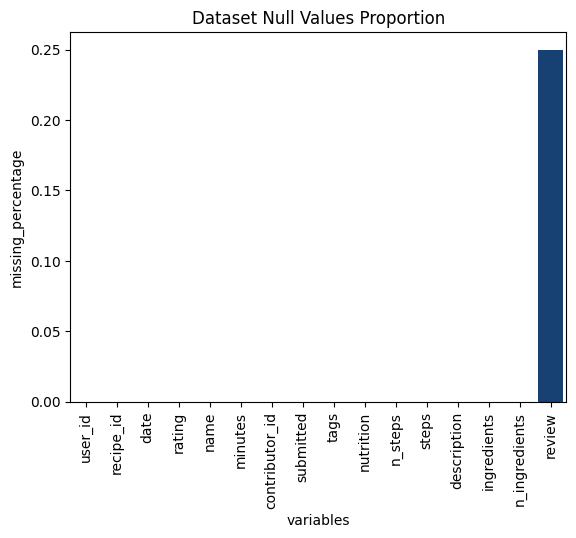

In [ ]:
sns.barplot(data=df_missing,
            x="variables",
            y="missing_percentage",
            palette='Blues')
plt.title("Dataset Null Values Proportion")
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
df_duplicated = df[df.duplicated(keep=False)]
df_duplicated.shape

(0, 16)

<ipython-input-8-8e57fe26c637>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ratings_distribution = sns.countplot(data=df, x="rating", palette='Set1')


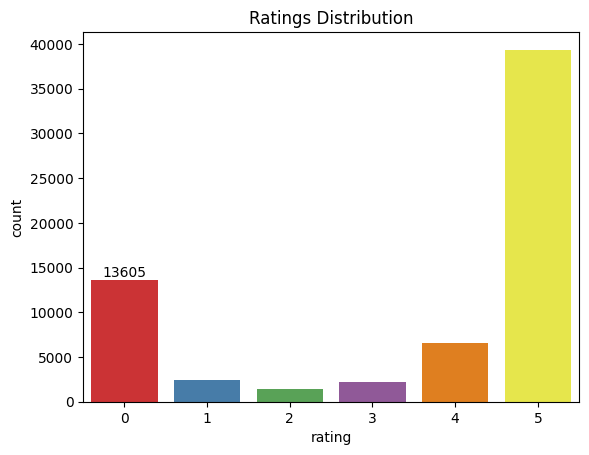

In [ ]:
plt.title("Ratings Distribution")
ratings_distribution = sns.countplot(data=df, x="rating", palette='Set1')
ratings_distribution.bar_label(ratings_distribution.containers[0])
plt.show()

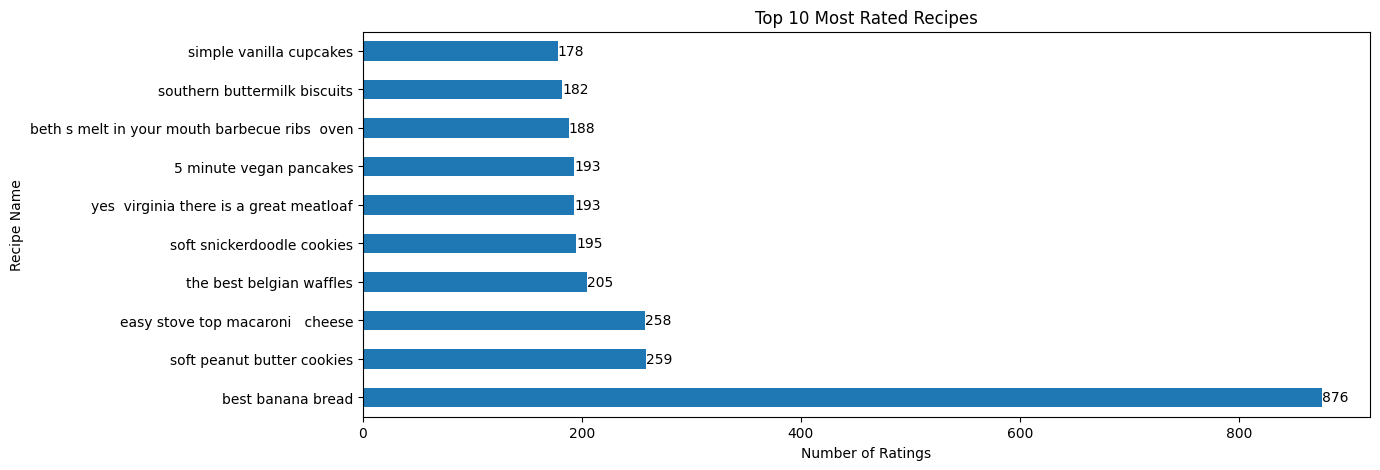

In [ ]:
plt.figure(figsize=(13, 5))
plt.title("Top 10 Most Rated Recipes")
ratings_per_recipe = df.groupby(
    "name")["rating"].count().sort_values(ascending=False)
bars = ratings_per_recipe.head(10).plot(kind='barh')
for bar in bars.containers:
    bars.bar_label(bar)
plt.xlabel("Number of Ratings")
plt.ylabel("Recipe Name")
plt.show()

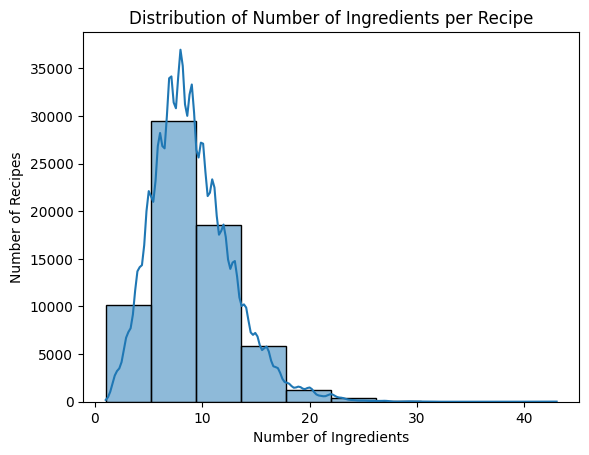

In [ ]:
sns.histplot(df["n_ingredients"], bins=10, kde=True)
plt.title("Distribution of Number of Ingredients per Recipe")
plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Recipes")
plt.show()

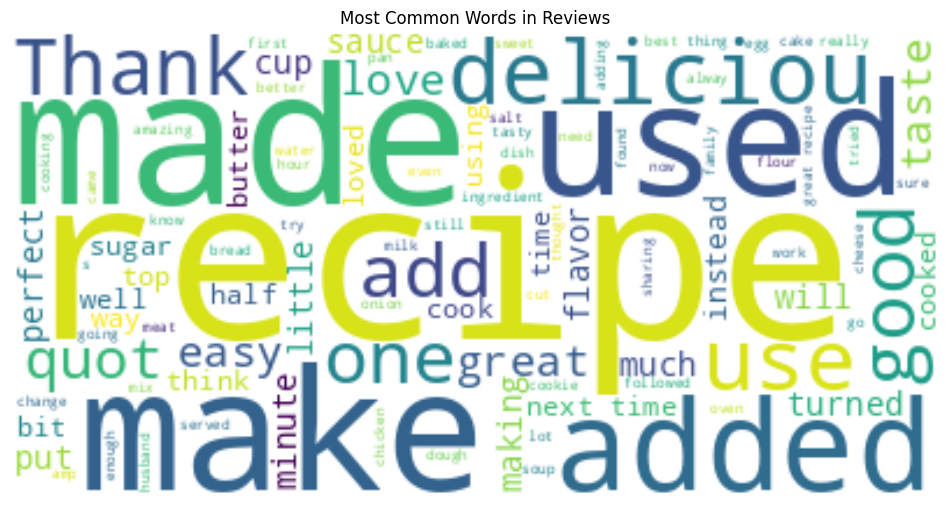

In [ ]:
text = ' '.join(df["review"].dropna().tolist())
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
plt.figure(figsize=(12, 10))
plt.title("Most Common Words in Reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

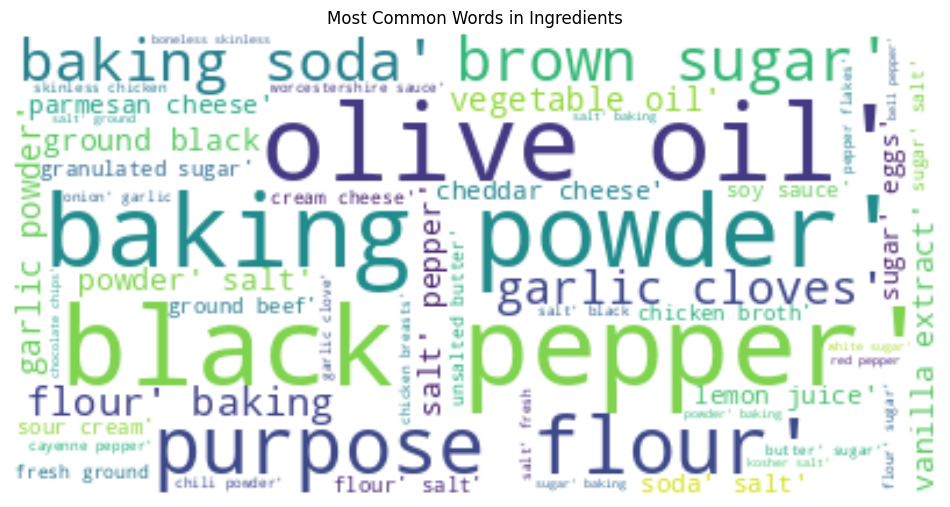

In [ ]:
text = ' '.join(df["ingredients"].dropna().tolist())
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
plt.figure(figsize=(12, 10))
plt.title("Most Common Words in Ingredients")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

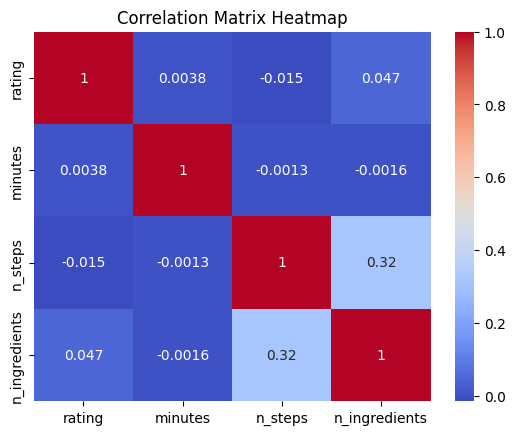

In [ ]:
corr_matrix = df[["rating", "minutes", "n_steps", "n_ingredients"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
users_with_one_rating = df["user_id"].value_counts()[df["user_id"].value_counts() == 1].index
df_filtered = df[~df["user_id"].isin(users_with_one_rating)]
train, test = train_test_split(df_filtered, test_size=0.3, random_state=100, stratify=df_filtered["user_id"])

In [ ]:
train.to_pickle('/content/train.pkl')
test.to_pickle('/content/test.pkl')

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
test.shape

(5851, 16)

In [ ]:
train.shape

(13652, 16)

In [ ]:
def unused_feat_removal(df, feature_to_remove):
    df.drop(columns=feature_to_remove, inplace=True)
    return df
feature_to_remove = ["date", "review", "name", "minutes", "contributor_id", "submitted",
                     "tags", "nutrition", "n_steps", "steps", "description", "ingredients", "n_ingredients"]

In [ ]:
unused_feat_removal(train, feature_to_remove)
unused_feat_removal(test, feature_to_remove)
train.shape

(13652, 3)

In [ ]:
train.head()

,user_id,recipe_id,rating
6622,2000865641,28768,5
58176,2001665627,61563,4
14378,288146,290644,5
31587,910805,148424,5
56121,2002114428,282620,2


In [ ]:
def create_mappings(train, test):
    user_mapping = {user: i for i, user in enumerate(
        train["user_id"].unique())}
    all_recipe_ids = np.union1d(
        train["recipe_id"].unique(), test["recipe_id"].unique())
    recipe_mapping = {recipe: i for i, recipe in enumerate(all_recipe_ids)}
    return user_mapping, recipe_mapping


def apply_mappings(df, user_mapping, recipe_mapping):
    df["user_id_mapped"] = df["user_id"].map(user_mapping).astype(int)
    df["recipe_id_mapped"] = df["recipe_id"].map(recipe_mapping).astype(int)
    return df


def create_sparse_user_item_matrix(df, n_users, n_items):
    rows = df["user_id_mapped"].values
    cols = df["recipe_id_mapped"].values
    data = df["rating"].values
    return csr_matrix((data, (rows, cols)), shape=(n_users, n_items))

In [ ]:
user_mapping, recipe_mapping = create_mappings(train, test)
train = apply_mappings(train, user_mapping, recipe_mapping)
test = apply_mappings(test, user_mapping, recipe_mapping)
n_users = len(np.unique(np.concatenate(
    [train["user_id_mapped"].values, test["user_id_mapped"].values])))
n_items = len(np.unique(np.concatenate(
    [train["recipe_id_mapped"].values, test["recipe_id_mapped"].values])))
train_sparse_matrix = create_sparse_user_item_matrix(train, n_users, n_items)
test_sparse_matrix = create_sparse_user_item_matrix(test, n_users, n_items)

In [ ]:
def calculate_sparsity(sparse_matrix):
    matrix_size = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    num_non_zero = sparse_matrix.nnz
    sparsity = (1 - (num_non_zero / matrix_size)) * 100
    return sparsity

In [ ]:
train_sparsity = calculate_sparsity(train_sparse_matrix)
test_sparsity = calculate_sparsity(test_sparse_matrix)

print(f"Training Matrix Sparsity: {train_sparsity}%")
print(f"Testing Matrix Sparsity: {test_sparsity}%")

Training Matrix Sparsity: 99.9752324744857%
Testing Matrix Sparsity: 99.98938508703603%


In [ ]:
train_dense_submatrix = train_sparse_matrix[:10, :10].todense()
train_submatrix = pd.DataFrame(train_dense_submatrix)
train_submatrix

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_dense_submatrix = train_sparse_matrix[:10, :10].todense()
test_submatrix = pd.DataFrame(test_dense_submatrix)

In [ ]:
with open('/content/train_sparse_matrix.pkl', 'wb') as file:
    pickle.dump(train_sparse_matrix, file)

with open('/content/test_sparse_matrix.pkl', 'wb') as file:
    pickle.dump(test_sparse_matrix, file)

with open('/content/user_mapping.pkl', 'wb') as file:
    pickle.dump(user_mapping, file)

with open('/content/recipe_mapping.pkl', 'wb') as file:
    pickle.dump(recipe_mapping, file)

In [ ]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import NearestNeighbors

In [ ]:
def train_svd_model(train_matrix, test_matrix, k=20):
    train_matrix = train_matrix.astype(np.float32)
    test_matrix = test_matrix.astype(np.float32)
    u, s, vt = svds(train_matrix, k=k)
    s_matrix = np.diag(s)
    svd_model = {"u": u, "s": s_matrix, "vt": vt}
    reconstructed_train_matrix = np.dot(np.dot(u, s_matrix), vt)
    y_train_true = np.squeeze(train_matrix[train_matrix.nonzero()].A)
    y_train_pred = np.squeeze(
        reconstructed_train_matrix[train_matrix.nonzero()])

    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    reconstructed_test_matrix = reconstructed_train_matrix
    y_test_true = np.squeeze(test_matrix[test_matrix.nonzero()].A)
    y_test_pred = np.squeeze(reconstructed_test_matrix[test_matrix.nonzero()])

    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    return svd_model, {"Train RMSE": train_rmse, "Train MAE": train_mae, "Test RMSE": test_rmse, "Test MAE": test_mae}




In [ ]:
def train_knn_model(train_matrix, test_matrix, n_neighbors=5):
    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model_knn.fit(train_matrix)
    y_train_pred = np.zeros(train_matrix.shape)
    for i in range(train_matrix.shape[0]):
        distances, indices = model_knn.kneighbors(train_matrix.getrow(
            i).toarray().reshape(1, -1), return_distance=True)
        distances = distances.flatten()
        indices = indices.flatten()
        weights = 1 / (1 + distances)
        neighbors_data = train_matrix[indices].toarray()
        y_train_pred[i] = np.dot(weights, neighbors_data) / np.sum(weights)
    train_nz_row, train_nz_col = train_matrix.nonzero()
    y_train_true = np.array(train_matrix[train_nz_row, train_nz_col]).flatten()
    non_zero_train_pred = np.array(
        y_train_pred[train_nz_row, train_nz_col]).flatten()
    train_rmse = np.sqrt(mean_squared_error(
        y_train_true, non_zero_train_pred))
    train_mae = mean_absolute_error(y_train_true, non_zero_train_pred)
    y_test_pred = np.zeros(test_matrix.shape)
    for i in range(test_matrix.shape[0]):
        distances, indices = model_knn.kneighbors(test_matrix.getrow(
            i).toarray().reshape(1, -1), return_distance=True)
        distances = distances.flatten()
        indices = indices.flatten()
        weights = 1 / (1 + distances)
        neighbors_data = train_matrix[indices].toarray()
        y_test_pred[i] = np.dot(weights, neighbors_data) / np.sum(weights)
    test_nz_row, test_nz_col = test_matrix.nonzero()
    y_test_true = np.array(test_matrix[test_nz_row, test_nz_col]).flatten()
    non_zero_test_pred = np.array(
        y_test_pred[test_nz_row, test_nz_col]).flatten()
    test_rmse = np.sqrt(mean_squared_error(
        y_test_true, non_zero_test_pred))
    test_mae = mean_absolute_error(y_test_true, non_zero_test_pred)
    cosine_similarity = np.mean(1 / (1 + np.array(distances)))
    return model_knn, {"Train RMSE": train_rmse, "Train MAE": train_mae, "Test RMSE": test_rmse, "Test MAE": test_mae, "CosineSimilarity": cosine_similarity}

In [ ]:
svd_model, svd_metrics = train_svd_model(
    train_sparse_matrix, test_sparse_matrix, k=20)

In [ ]:
knn_model, knn_metrics = train_knn_model(
    train_sparse_matrix, test_sparse_matrix, n_neighbors=3)

In [ ]:
models_metrics = pd.DataFrame([svd_metrics, knn_metrics], index=["SVD", "KNN"])
models_metrics

,Train RMSE,Train MAE,Test RMSE,Test MAE,CosineSimilarity
SVD,4.147665,3.663980,4.688099,4.612343,NaN
KNN,2.180912,1.997106,4.025376,3.650300,0.5


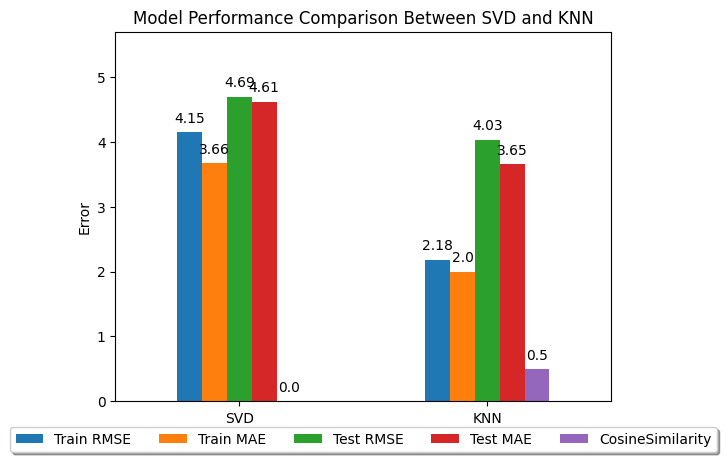

In [ ]:
ax = models_metrics.plot(kind='bar')
plt.title("Model Performance Comparison Between SVD and KNN")
plt.ylabel("Error")
plt.xticks(rotation=0)
ylim_max = models_metrics.max().max() + 1
plt.ylim(0, ylim_max)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.legend(loc='upper center', bbox_to_anchor=(
    0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

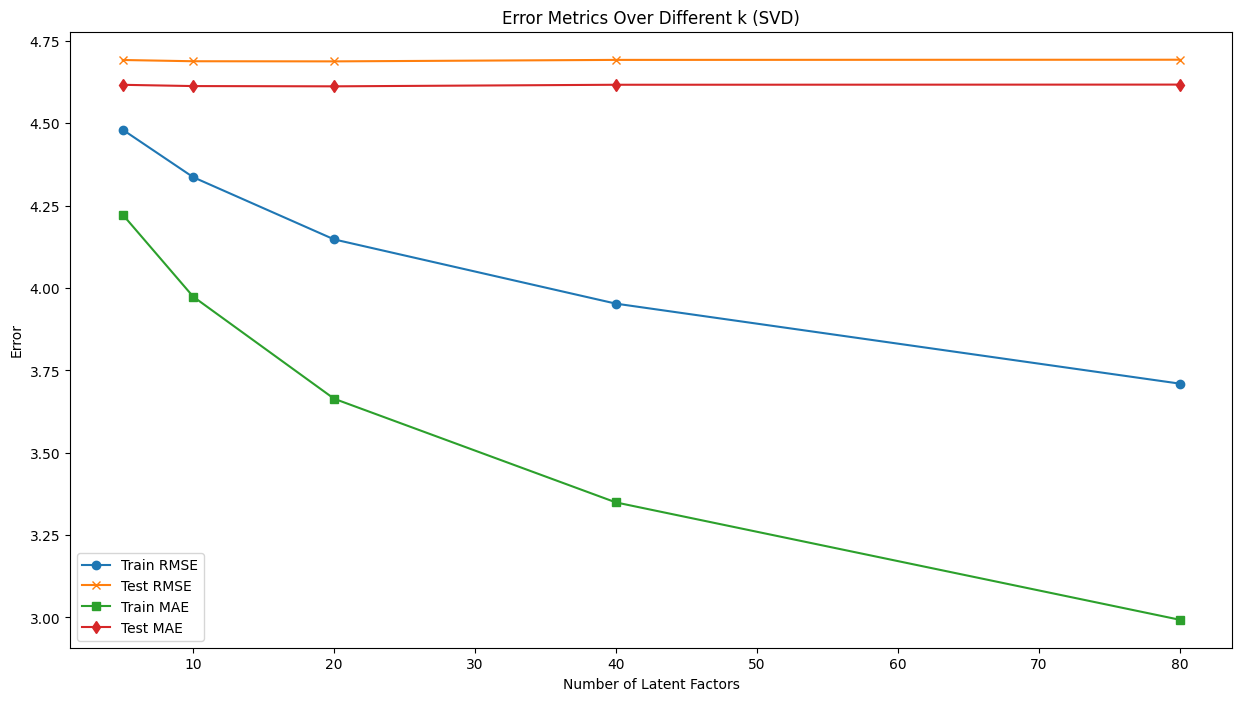

In [ ]:
ks = [5, 10, 20, 40, 80]
train_svd_rmse = []
test_svd_rmse = []
train_svd_mae = []
test_svd_mae = []
for k in ks:
    _, metrics = train_svd_model(train_sparse_matrix, test_sparse_matrix, k=k)
    train_svd_rmse.append(metrics["Train RMSE"])
    test_svd_rmse.append(metrics["Test RMSE"])
    train_svd_mae.append(metrics["Train MAE"])
    test_svd_mae.append(metrics["Test MAE"])
plt.figure(figsize=(15, 8))
plt.plot(ks, train_svd_rmse, label="Train RMSE", marker='o')
plt.plot(ks, test_svd_rmse, label="Test RMSE", marker='x')
plt.plot(ks, train_svd_mae, label="Train MAE", marker='s')
plt.plot(ks, test_svd_mae, label="Test MAE", marker='d')
plt.title("Error Metrics Over Different k (SVD)")
plt.xlabel("Number of Latent Factors")
plt.ylabel("Error")
plt.legend()
plt.show()

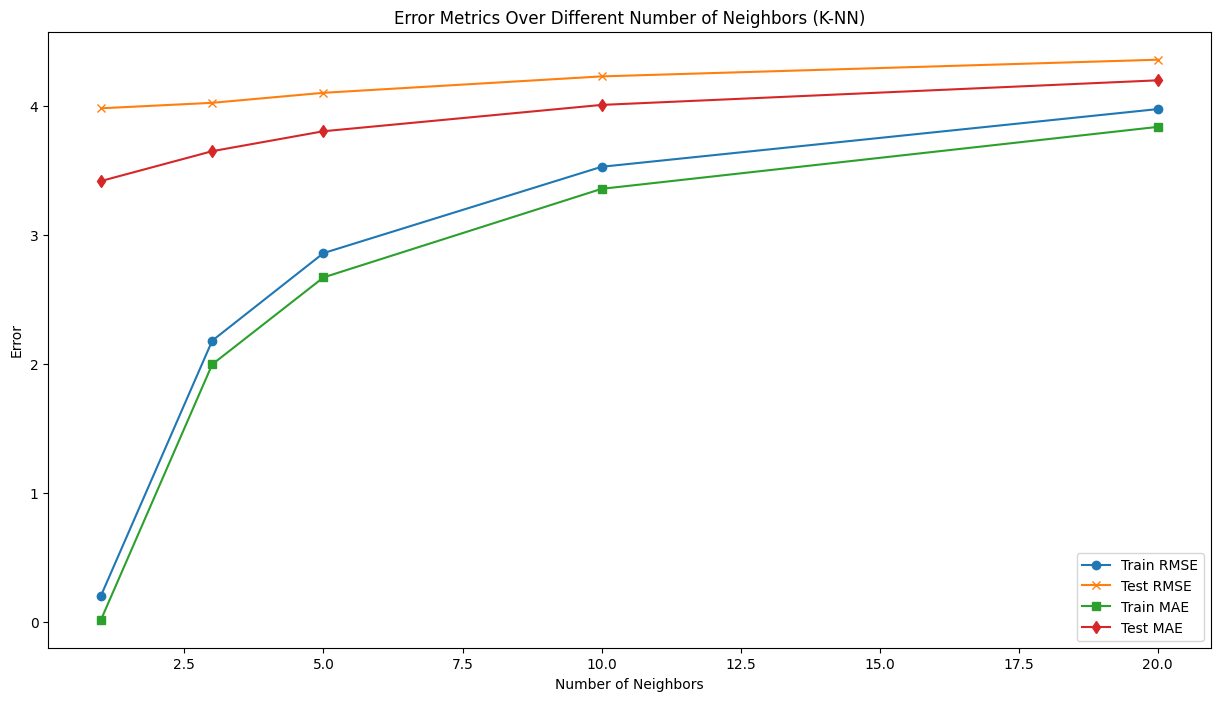

In [ ]:
n_neighbors_values = [1, 3, 5, 10, 20]
train_knn_rmse = []
test_knn_rmse = []
train_knn_mae = []
test_knn_mae = []
for n in n_neighbors_values:
    _, metrics = train_knn_model(
        train_sparse_matrix, test_sparse_matrix, n_neighbors=n)
    train_knn_rmse.append(metrics["Train RMSE"])
    test_knn_rmse.append(metrics["Test RMSE"])
    train_knn_mae.append(metrics["Train MAE"])
    test_knn_mae.append(metrics["Test MAE"])
plt.figure(figsize=(15, 8))
plt.plot(n_neighbors_values, train_knn_rmse, label="Train RMSE", marker='o')
plt.plot(n_neighbors_values, test_knn_rmse, label="Test RMSE", marker='x')
plt.plot(n_neighbors_values, train_knn_mae, label="Train MAE", marker='s')
plt.plot(n_neighbors_values, test_knn_mae, label="Test MAE", marker='d')
plt.title("Error Metrics Over Different Number of Neighbors (K-NN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("Error")
plt.legend()
plt.show()

In [ ]:
with open('/content/best_model.pkl', 'wb') as file:
   pickle.dump(knn_model, file)